# Audio reconstruction with Inpainting GAN

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import pandas as pd
import random 
import copy
from numpy import savez_compressed, load
import keras.backend as K
from keras import regularizers
from keras.layers import Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
#from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Activation, Dense
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise, Conv2DTranspose
from keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import gc
import IPython.display as ipd
from tqdm import tqdm

import scipy.misc
from scipy import ndimage

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Loading data

In [3]:
def plot_spectrogram(X): # note that sr is variable 
  sr=16000
  fig, ax = plt.subplots()
  S_dB = librosa.power_to_db(X, ref=np.max)
  img = librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=sr,
                          hop_length=160,
                          fmin=125, 
                          fmax=7500, ax=ax)
  '''
  x_mel = librosa.feature.melspectrogram(y=sample_padded.numpy(),
                                       sr=16000, 
                                       hop_length=160,
                                       win_length=400,
                                       window='hann',
                                       n_mels=64, 
                                       fmin=125, 
                                       fmax=7500)
  '''
  fig.colorbar(img, ax=ax, format='%+2.0f dB')
  ax.set(title='Mel-frequency spectrogram')

In [4]:
# load dict of arrays
dict_data = load("/content/gdrive/MyDrive/UrbanSound8K/dati/dataset16kHz.npz")
# extract the first array
data = dict_data['arr_0']
data = data.reshape(-1,64000,1)

In [5]:
x = data[7, :]
x_corr = copy.deepcopy(x)
x_corr[5000:13000]=0
x_missing = data[7, 5000:13000]

In [6]:
print("Waveform shape: ", x.shape)
print("Corruption shape: ", x_missing.shape)
print("Waveform shape after reshape(-1): ", x.reshape(-1).shape)
print("Corruption shape after reshape(-1): ", x_missing.reshape(-1).shape)

Waveform shape:  (64000, 1)
Corruption shape:  (8000, 1)
Waveform shape after reshape(-1):  (64000,)
Corruption shape after reshape(-1):  (8000,)


In [7]:
def pad_waveform(waveform):
        sample_rate = 16000.0
        stft_window_seconds = 0.025
        stft_hop_seconds = 0.010
        mel_bands = 64
        mel_min_hz = 125.0
        mel_max_hz = 7500.0
        log_offset = 0.001
        patch_window_seconds = 0.96
        patch_hop_seconds = 0.48
        
        """Pads waveform with silence if needed to get an integral number of patches."""
        # In order to produce one patch of log mel spectrogram input to YAMNet, we
        # need at least one patch window length of waveform plus enough extra samples
        # to complete the final STFT analysis window.
        min_waveform_seconds = (
            patch_window_seconds +
            stft_window_seconds - stft_hop_seconds)
        min_num_samples = tf.cast(min_waveform_seconds * sample_rate, tf.int32)
        num_samples = tf.shape(waveform)[0]
        num_padding_samples = tf.maximum(0, min_num_samples - num_samples)

        # In addition, there might be enough waveform for one or more additional
        # patches formed by hopping forward. If there are more samples than one patch,
        # round up to an integral number of hops.
        num_samples = tf.maximum(num_samples, min_num_samples)
        num_samples_after_first_patch = num_samples - min_num_samples
        hop_samples = tf.cast(patch_hop_seconds * sample_rate, tf.int32)
        num_hops_after_first_patch = tf.cast(tf.math.ceil(
                tf.cast(num_samples_after_first_patch, tf.float32) /
                tf.cast(hop_samples, tf.float32)), tf.int32)
        num_padding_samples += (
            hop_samples * num_hops_after_first_patch - num_samples_after_first_patch)

        padded_waveform = tf.pad(waveform, [[0, num_padding_samples]],
                                mode='CONSTANT', constant_values=0.0)
        return padded_waveform

In [8]:
sample_padded = pad_waveform(x.reshape(64000).astype("float32"))

In [9]:
sample_padded_corr = pad_waveform(x_corr.reshape(64000).astype("float32"))

In [10]:
sample_padded.numpy().shape

(69360,)

In [11]:
x_missing.shape

(8000, 1)

In [12]:
x_mel = librosa.feature.melspectrogram(y=sample_padded.numpy(),
                                       sr=16000, 
                                       hop_length=160,
                                       win_length=400,
                                       window='hann',
                                       n_mels=64, 
                                       fmin=125, 
                                       fmax=7500)
x_corr_mel = librosa.feature.melspectrogram(y=sample_padded_corr.numpy(),
                                       sr=16000, 
                                       hop_length=160,
                                       win_length=400,
                                       window='hann',
                                       n_mels=64, 
                                       fmin=125, 
                                       fmax=7500)
x_missing_mel = librosa.feature.melspectrogram(y=x_missing.reshape(-1),
                                       sr=16000, 
                                       hop_length=160,
                                       win_length=400,
                                       window='hann',
                                       n_mels=64, 
                                       fmin=125, 
                                       fmax=7500)

In [13]:
x_log_mel = np.log(x_mel+0.001)

In [14]:
x_mel.shape

(64, 434)

In [15]:
x_missing_mel.shape

(64, 51)

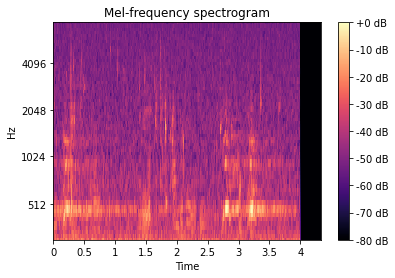

In [16]:
plot_spectrogram(x_mel)

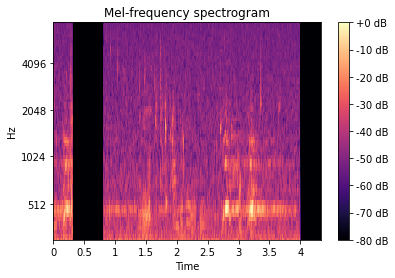

In [17]:
plot_spectrogram(x_corr_mel)

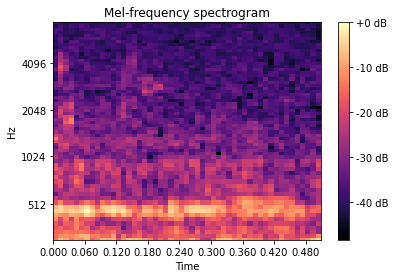

In [18]:
plot_spectrogram(x_missing_mel)

# Inpainting GAN (16kHz data)
The code is inspired by: 

1) https://github.com/eriklindernoren/Keras-GAN/blob/master/context_encoder/context_encoder.py

2) https://github.com/ced211/master_thesis/tree/master/python

Dec input shape:  (13, 16, 512)
Rec frame shape:  (13, 64, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 20, 32, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 16, 64)        18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 5, 8, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 5120)              0         
                                                                 
 dense (Dense)               (None, 1)                 5121      
                                                                 
Total params: 97,793
Trainable params: 97,793
Non-trainable params: 0
______________________________________________________

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


(64, 13)
11 [D loss: 0.692085, acc: 50.00%] [G loss: 0.068602, mae: 0.0000000000000000]
12 [D loss: 0.692371, acc: 50.00%] [G loss: 0.069034, mae: 0.0000000000000000]
13 [D loss: 0.638950, acc: 100.00%] [G loss: 0.076317, mae: 0.0000000000000000]
14 [D loss: 0.693805, acc: 50.00%] [G loss: 0.068190, mae: 0.0000000000000000]
15 [D loss: 0.667844, acc: 50.00%] [G loss: 0.067745, mae: 0.0000000000000000]
16 [D loss: 0.698754, acc: 50.00%] [G loss: 0.066772, mae: 0.0000000000000000]
17 [D loss: 0.693227, acc: 50.00%] [G loss: 0.069019, mae: 0.0000000000000000]
18 [D loss: 0.633517, acc: 100.00%] [G loss: 0.071928, mae: 0.0000000000000000]
19 [D loss: 0.670062, acc: 50.00%] [G loss: 0.068843, mae: 0.0000000000000000]
20 [D loss: 0.683845, acc: 50.00%] [G loss: 0.071910, mae: 0.0000000000000000]
6
(64, 13)
(64, 13)
(64, 13)
(64, 13)
(64, 13)
(64, 13)
21 [D loss: 0.672623, acc: 100.00%] [G loss: 0.069459, mae: 0.0000000000000000]
22 [D loss: 0.494568, acc: 100.00%] [G loss: 0.090915, mae: 0.0

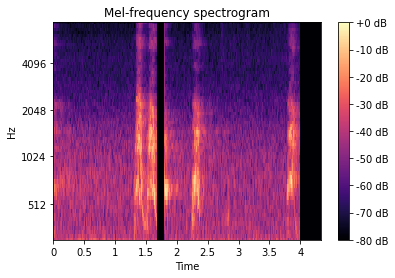

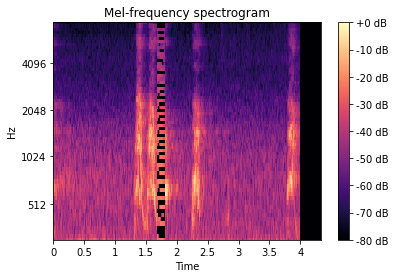

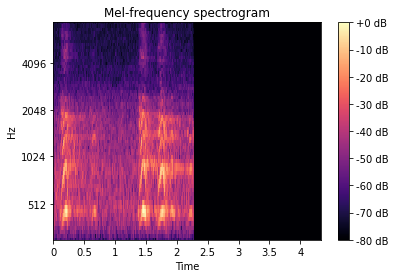

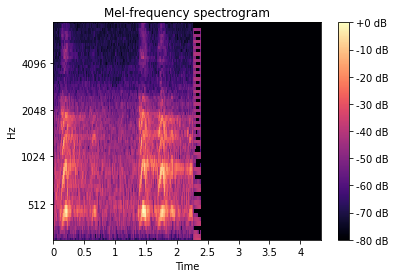

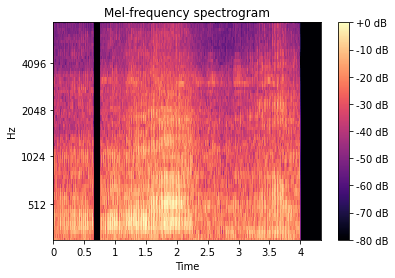

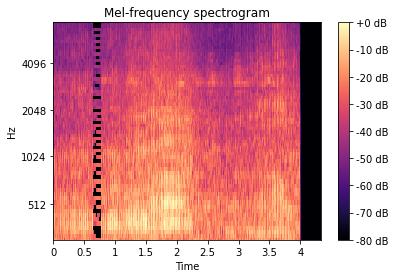

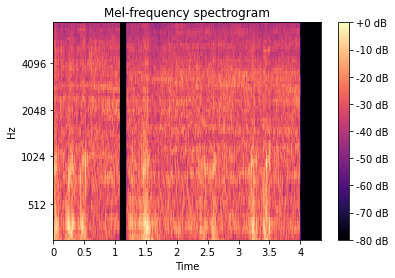

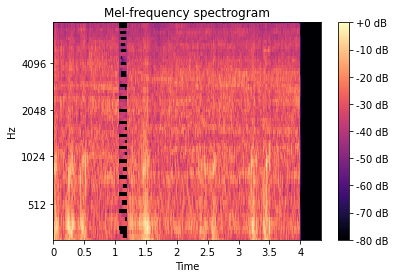

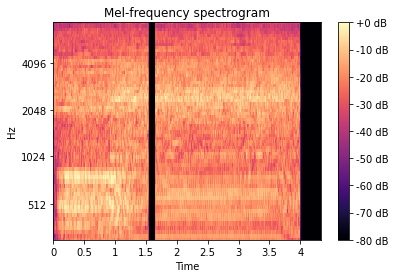

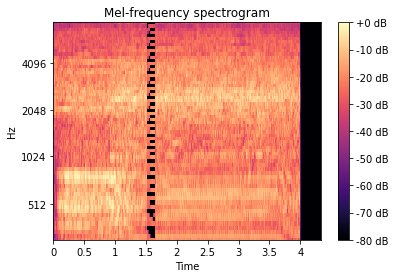

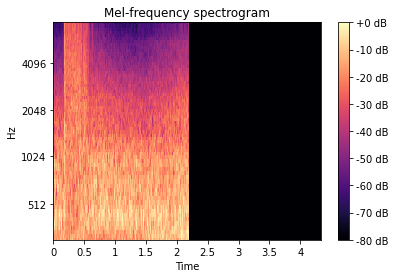

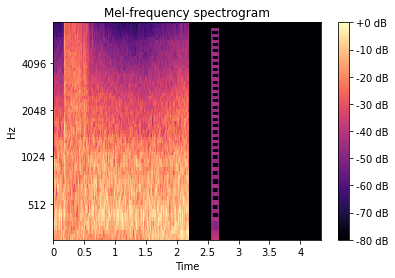

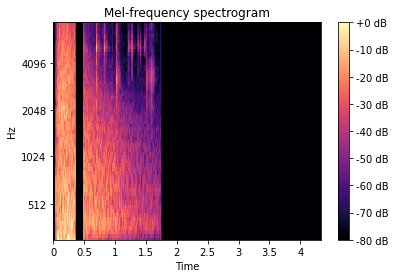

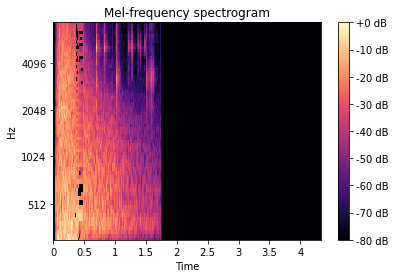

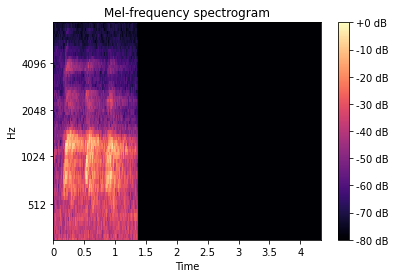

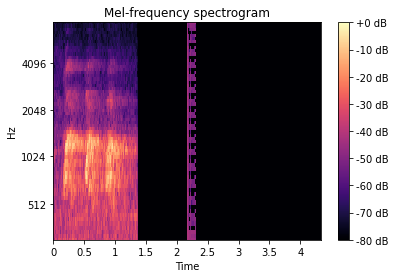

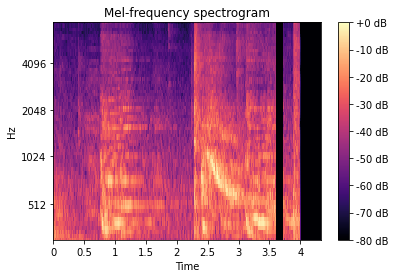

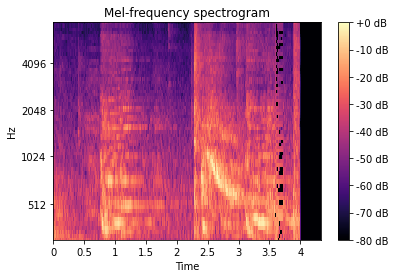

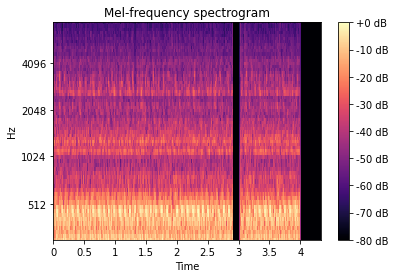

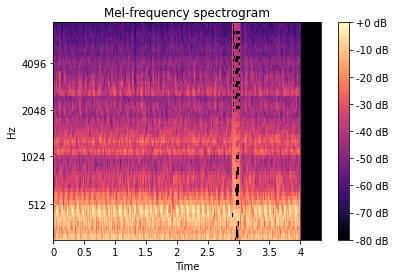

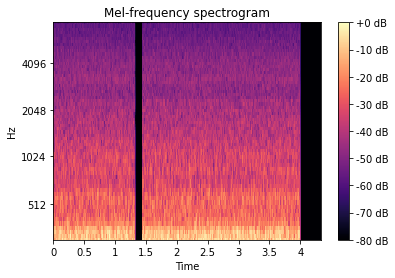

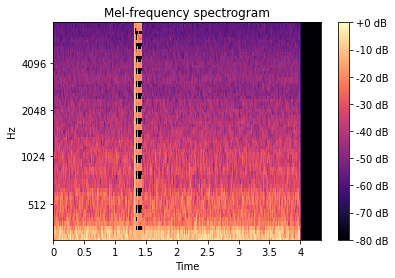

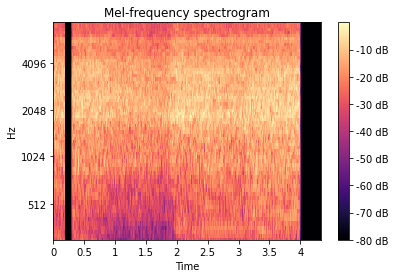

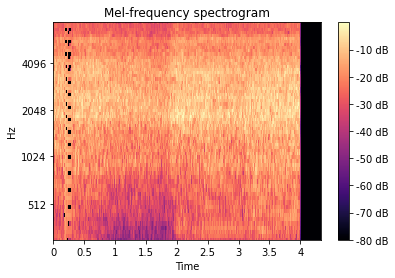

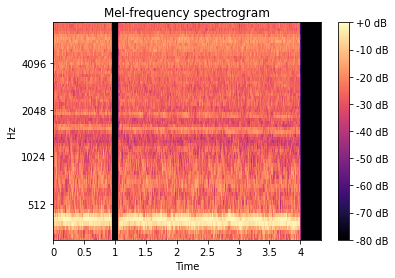

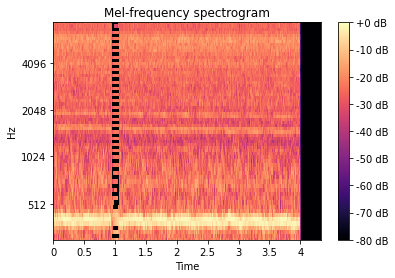

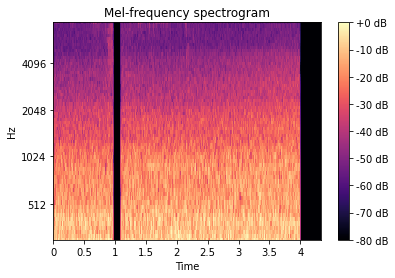

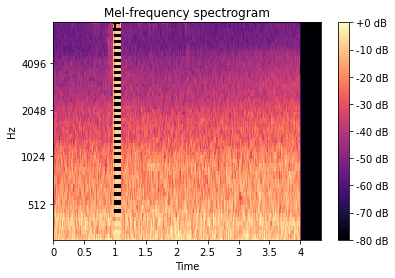

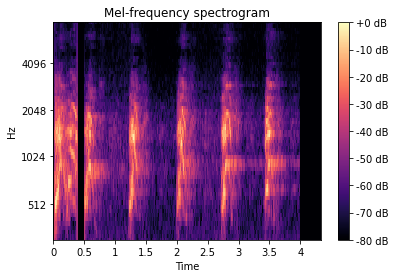

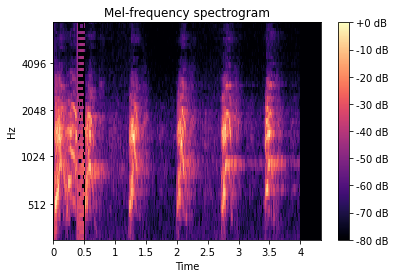

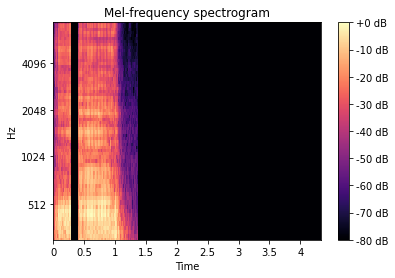

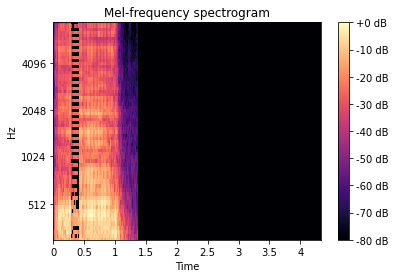

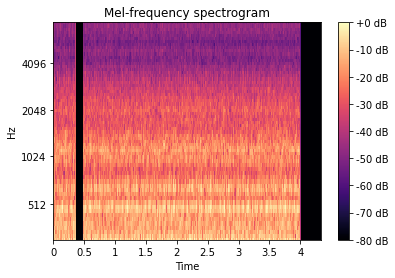

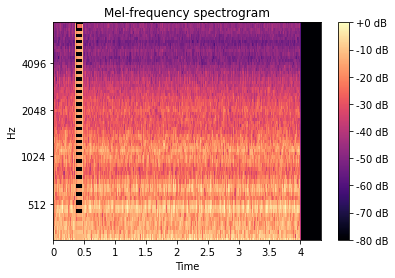

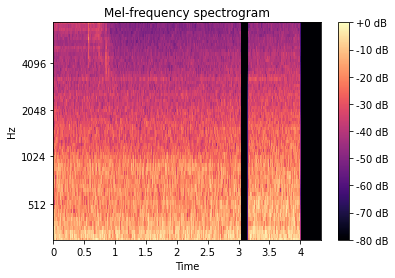

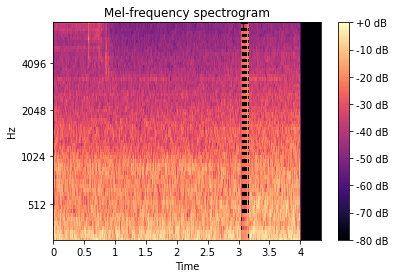

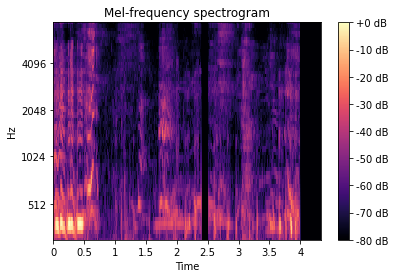

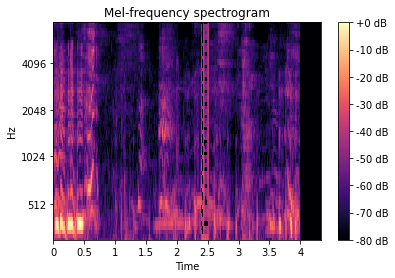

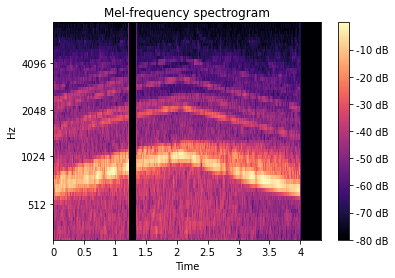

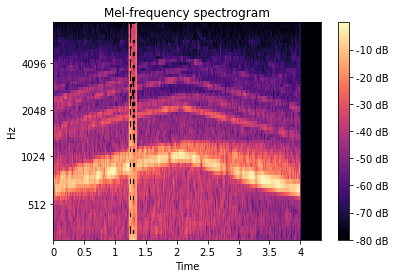

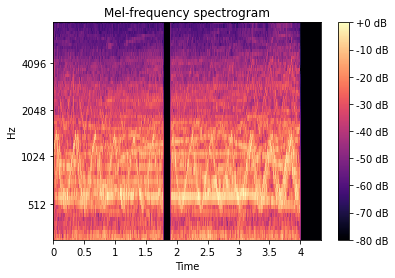

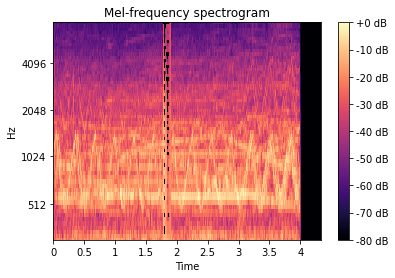

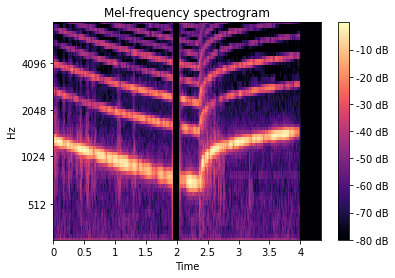

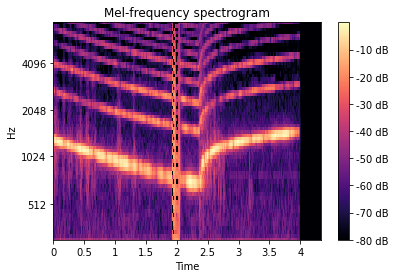

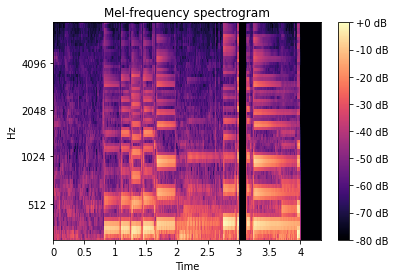

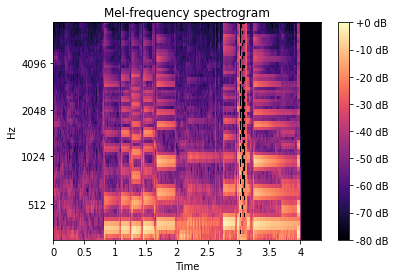

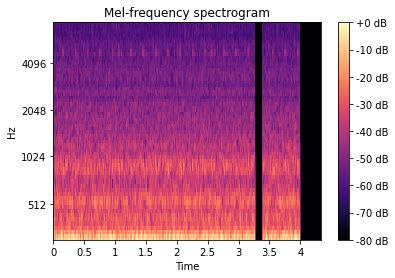

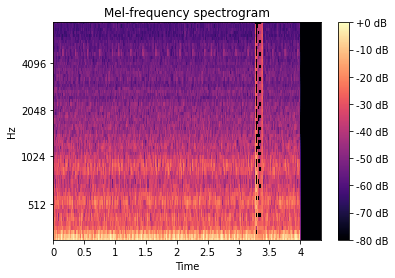

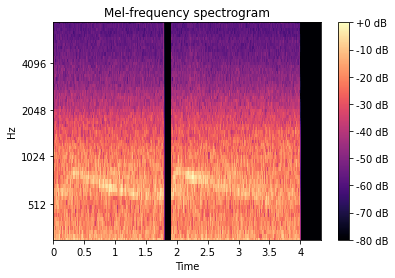

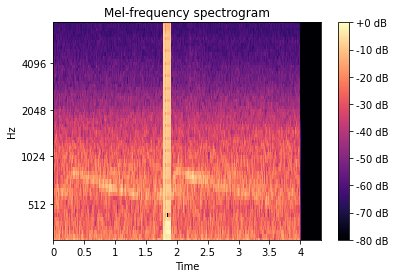

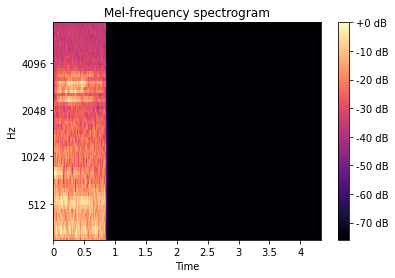

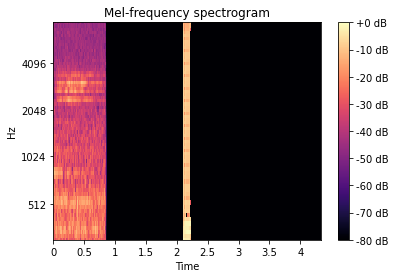

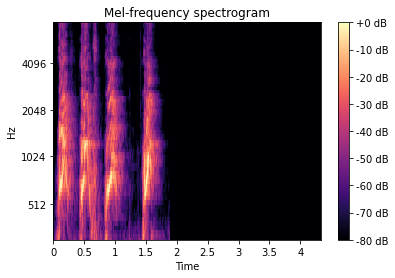

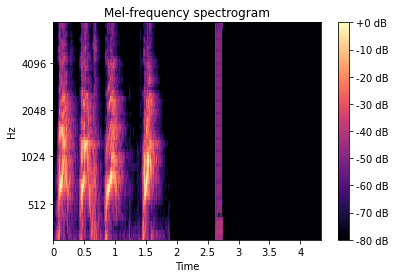

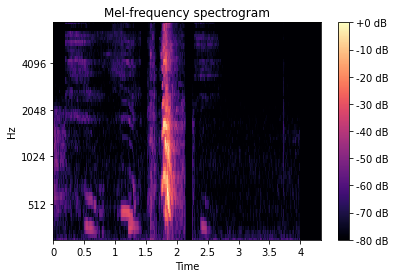

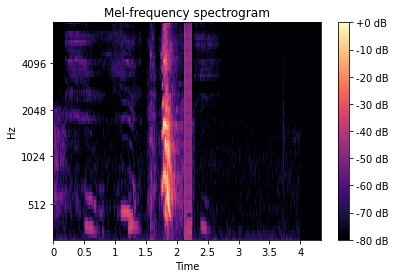

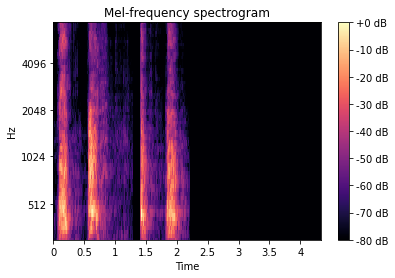

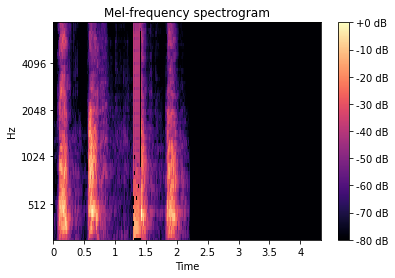

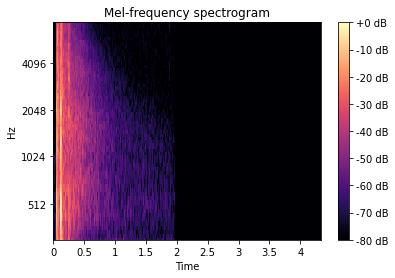

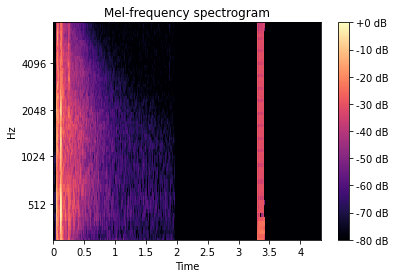

In [19]:
from __future__ import print_function, division
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import os
import time
import librosa.display
import numpy as np

# setting a random seed
SEED=42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['TF_CUDNN_DETERMINISTIC']='1'

class ContextEncoder():
    def __init__(self, corr_length):
        # 16 kHz * 10 ms = 160 hop length 
        self.mask_height = 64
        self.channels = 1
        self.sr=16000 # sampling rate
        self.corruption_length = corr_length
        if(corr_length==16000):
          self.mask_width = 101 
        if(corr_length==8000):
          self.mask_width = 51
        elif(corr_length==4000):
          self.mask_width = 26
        elif(corr_length==2000):
          self.mask_width = 13 # 12.5
        elif(corr_length==1000):
          self.mask_width = 7 # 6.25
        elif(corr_length==500):
          self.mask_width = 4 # 3.125 
        self.input_shape = (self.mask_width, self.mask_height, self.channels)

        optimizer = Adam(0.0001, 0.9)
        # 0.001, 0.9, 0.099 not working
        # 0.0001, 0.5

        # Build the generator
        self.generator = self.build_generator_igan()

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator_igan()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) 

        # Model initialization
        prev_frame_shape = Input(shape=self.input_shape)
        next_frame_shape = Input(shape=self.input_shape)
        gen_missing = self.generator([prev_frame_shape,next_frame_shape], training=True)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines
        # if it is generated or if it is a real image
        valid = self.discriminator([prev_frame_shape, gen_missing, next_frame_shape])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([prev_frame_shape,next_frame_shape] , [gen_missing, valid])
        self.combined.compile(loss=['mae', 'binary_crossentropy'], # it was mse
            loss_weights=[0.9, 0.1], # it was loss_weights=[0.999, 0.001]
            optimizer=optimizer)

    # from pad_waveform in yamnet/features.py
    def pad_waveform(self, waveform):
        sample_rate = 16000.0
        stft_window_seconds = 0.025
        stft_hop_seconds = 0.010
        mel_bands = 64
        mel_min_hz = 125.0
        mel_max_hz = 7500.0
        log_offset = 0.001
        patch_window_seconds = 0.96
        patch_hop_seconds = 0.48
        
        """Pads waveform with silence if needed to get an integral number of patches."""
        # In order to produce one patch of log mel spectrogram input to YAMNet, we
        # need at least one patch window length of waveform plus enough extra samples
        # to complete the final STFT analysis window.
        min_waveform_seconds = (
            patch_window_seconds +
            stft_window_seconds - stft_hop_seconds)
        min_num_samples = tf.cast(min_waveform_seconds * sample_rate, tf.int32)
        num_samples = tf.shape(waveform)[0]
        num_padding_samples = tf.maximum(0, min_num_samples - num_samples)

        # In addition, there might be enough waveform for one or more additional
        # patches formed by hopping forward. If there are more samples than one patch,
        # round up to an integral number of hops.
        num_samples = tf.maximum(num_samples, min_num_samples)
        num_samples_after_first_patch = num_samples - min_num_samples
        hop_samples = tf.cast(patch_hop_seconds * sample_rate, tf.int32)
        num_hops_after_first_patch = tf.cast(tf.math.ceil(
                tf.cast(num_samples_after_first_patch, tf.float32) /
                tf.cast(hop_samples, tf.float32)), tf.int32)
        num_padding_samples += (
            hop_samples * num_hops_after_first_patch - num_samples_after_first_patch)

        padded_waveform = tf.pad(waveform, [[0, num_padding_samples]],
                                mode='CONSTANT', constant_values=0.0)
        return padded_waveform

    def build_generator_igan(self):

        encoder = Sequential()
        # Encoder
        encoder.add(Conv2D(32, kernel_size=(4,6), strides=(1,2), input_shape=self.input_shape, padding="same", activation="relu"))
        encoder.add(Conv2D(64, kernel_size=(4,6), strides=(1,2), padding="same", activation="relu"))
        encoder.add(Conv2D(128, kernel_size=(4,6), strides=(1,1), padding="same", activation="relu"))
        encoder.add(Conv2D(256, kernel_size=(4,6), strides=(1,1), padding="same",activation="relu"))

        # 3.4 
        spec1 = tf.keras.Input(shape=self.input_shape)
        spec3 = tf.keras.Input(shape=self.input_shape)

        spec1_encoded = encoder(spec1)
        spec3_encoded = encoder(spec3)
        
        # Layer that concatenates a list of inputs. It takes as input a list of tensors, all of the same shape except for the concatenation axis,
        # and returns a single tensor that is the concatenation of all inputs
        dec_input = Concatenate()([spec1_encoded, spec3_encoded])
        
        print("Dec input shape: ", dec_input.shape[1:]) # (16, 32, 512) 

        decoder = Sequential()
        # Decoder
        decoder.add(Conv2DTranspose(256,kernel_size=(4,6), strides=(1,2), input_shape=dec_input.shape[1:], padding="same",activation="relu"))
        decoder.add(Conv2DTranspose(128,kernel_size=(4,6), strides=(1,2), padding="same",activation="relu"))
        decoder.add(Conv2DTranspose(64,kernel_size=(4,6), strides=(1,1), padding="same",activation="relu")) # stride was (1,2)
        decoder.add(Conv2DTranspose(32,kernel_size=(4,6), strides=(1,1), padding="same",activation="relu"))
        decoder.add(Conv2DTranspose(1,kernel_size=(4,6), strides=(1,1), padding="same",activation="linear"))        
        
        prediction = decoder(dec_input)
        
        return Model([spec1, spec3], prediction)

    def build_discriminator_igan(self):    

        prev_frame = tf.keras.layers.Input(shape=self.input_shape, name='prev_frame') # (16, 128, 1)
        next_frame = tf.keras.layers.Input(shape=self.input_shape, name='next_frame') # (16, 128, 1)
        print("Rec frame shape: ",self.generator.layers[-1].output_shape[1:])
        rec_frame = tf.keras.layers.Input(shape=self.generator.layers[-1].output_shape[1:], name='rec_frame') # (16, 256, 1)
        input = tf.concat([prev_frame, rec_frame, next_frame], axis=1)

        model = Sequential()
        # Without batch normalization 
        # (48, 128, 1) where 48=16*3 (prima era 5, 512, 1)
        model.add(Conv2D(32, strides=(2, 2), kernel_size=(3, 3), input_shape=(self.mask_width*3, self.mask_height, 1), padding="same",activation="relu"))
        model.add(Conv2D(64, strides=(2, 2), kernel_size=(3, 3), padding="same",activation="relu"))
        model.add(Conv2D(128, strides=(2, 2), kernel_size=(3, 3), padding="same",activation="relu"))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        last = model(input)

        return Model(inputs=[prev_frame, rec_frame, next_frame], outputs=last, name="discriminator")

    def mask_randomly(self, imgs_original):
        imgs = copy.deepcopy(imgs_original)
        # waveform corruption        
        masked_imgs = []
        imgs_mel = []
        missing_parts = np.empty((imgs.shape[0], self.corruption_length, self.channels))
        masked_imgs_mel = []
        missing_parts_mel = []
        x1 = [] # da togliere (non serve più)
        x2 = []
        x1_mel = []
        x2_mel = [] 
        previous_frames = []
        gap_frames = []
        next_frames = []
        for i, sample in enumerate(imgs):
          sample_padded = self.pad_waveform(sample.reshape(64000).astype("float32")) # Reshape and casting required for the function to work properly 
          x_mel_librosa = librosa.feature.melspectrogram(y=sample_padded.numpy().reshape(-1), sr=self.sr,
                                         hop_length=160,
                                         win_length=400,
                                         fmin=125,
                                         fmax=7500,
                                         n_mels=64)
          imgs_mel.append(x_mel_librosa)
          # 400 = window size 
          rand1 = random.randint(self.corruption_length+400, int(len(sample)-3*self.corruption_length)) 
          zeros = np.zeros(shape=sample[rand1:].shape)
          if (sample[rand1:]==zeros).all() == True or sample[rand1:rand1+self.corruption_length, :].shape[0]<self.sr:
              rand1 = random.randint(self.corruption_length+400, int(len(sample)-3*self.corruption_length)) # 16000
              missing_parts[i]=sample[rand1:rand1+self.corruption_length, :]
          else:
              missing_parts[i]=sample[rand1:rand1+self.corruption_length, :]
          sample[rand1:rand1+self.corruption_length] = 0 
          masked_imgs.append(sample)
          # waveform to mel spectrogram 
          sample_padded_masked = self.pad_waveform(sample.reshape(64000).astype("float32")) # Reshape and casting required for the function to work properly 
          x_mel_librosa_masked = librosa.feature.melspectrogram(y=sample_padded_masked.numpy().reshape(-1), sr=16000,
                                         hop_length=160,
                                         win_length=400,
                                         fmin=125,
                                         fmax=7500,
                                         n_mels=64)
          masked_imgs_mel.append(x_mel_librosa_masked)

          # non servono più
          x1.append(rand1)
          x2.append(rand1+self.corruption_length)

          r_mel = round(rand1/160) # corruption starting point (r='random')
          l_mel = self.mask_width  # corruption length (spectrogram) (l='length')

          x1_mel.append(round(rand1/160))
          x2_mel.append(round(r_mel+l_mel))

          # (16, 128) 
          previous_frames.append(imgs_mel[i][:,(r_mel-l_mel):r_mel].T) 
          gap_frames.append(imgs_mel[i][:, r_mel:(r_mel+l_mel)].T)
          next_frames.append(imgs_mel[i][:,(r_mel+l_mel):(r_mel + 2*l_mel)].T)

        # missing_parts is referred to the waveform, gap_frames is referred to the spectro
        return np.array(masked_imgs), missing_parts, masked_imgs_mel, imgs_mel, missing_parts_mel, previous_frames, gap_frames, next_frames, np.array(x1), np.array(x2), np.array(x1_mel), np.array(x2_mel)

    def train(self, epochs, batch_size=128, sample_interval=50):

        self.X_train = data
        self.data = data
        self.X_train = self.X_train.reshape(self.X_train.shape[0], 64000, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
          # ---------------------
          #  Train Discriminator
          # ---------------------

          # Select a random batch of images
          idx = np.random.randint(0, self.X_train.shape[0], batch_size)
          imgs = self.X_train[idx]
          #print(idx)

          # both referred to mel
          _, _, masked_imgs, missing_parts, imgs_mel, previous_frames, gap_frames, next_frames, _, _, _, _= self.mask_randomly(imgs)       

          # Generate a batch of new images
          for i in range(len(imgs)): # len(imgs)=64
            # es. (51,64)
            previous_frames[i] = previous_frames[i].reshape(1,self.mask_width,self.mask_height,1)
            gap_frames[i] = gap_frames[i].reshape(1,self.mask_width,self.mask_height,1)
            next_frames[i] = next_frames[i].reshape(1,self.mask_width,self.mask_height,1)
            gen_missing = self.generator([previous_frames[i], next_frames[i]])
            original_shape = gen_missing.shape
            # Train the discriminator          
            d_loss_real = self.discriminator.train_on_batch([previous_frames[i], gap_frames[i], next_frames[i]], valid[i])
            d_loss_fake = self.discriminator.train_on_batch([previous_frames[i], gen_missing, next_frames[i]], fake[i])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            # ---------------------
            #  Train Generator
            # ---------------------
            g_loss = self.combined.train_on_batch([previous_frames[i], next_frames[i]], [gen_missing, valid[i]]) 

          # Plot the progress
          print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mae: %.16f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))
          
          # If at save interval => save generated image samples
          if epoch % sample_interval == 0:
              idx = np.random.randint(0, self.X_train.shape[0], 6)
              imgs = self.X_train[idx]
              self.sample_images(epoch, imgs)
          gc.collect()   

    # bozza per salvare dataset ricostruito
    def save_images(self, imgs, path):
       reconstructed_audio = []
       cnt = 0 #contatore
       from tqdm import tqdm # progress bar
       _, _, masked_imgs, imgs_mel, _,  previous_frames, gap_frames, next_frames, x1, x2, x1_mel, x2_mel= self.mask_randomly(imgs) 
       print("result: ", x1_mel-x2_mel)
       for i in tqdm(range(2)): #range(len(imgs))
          previous_frames[i] = previous_frames[i].reshape(1,self.mask_width,self.mask_height,1)
          gap_frames[i] = gap_frames[i].reshape(1,self.mask_width,self.mask_height,1)
          next_frames[i] = next_frames[i].reshape(1,self.mask_width,self.mask_height,1)
          gen_missing = self.generator([previous_frames[i], next_frames[i]])
          masked_imgs[i][: , x1_mel[i]:x2_mel[i]] = gen_missing.numpy().reshape(self.mask_width,self.mask_height).T
          reconstructed_audio.append(masked_imgs[i])
       savez_compressed(path, reconstructed_audio)

    def sample_images(self, epoch, imgs):      

        '''
         return np.array(masked_imgs), missing_parts, masked_imgs_mel, imgs_mel, missing_parts_mel, previous_frames, gap_frames, next_frames, np.array(x1), np.array(x2), np.array(x1_mel), np.array(x2_mel)
        '''
        _, _, masked_imgs, imgs_mel, _, previous_frames, gap_frames, next_frames, x1, x2, x1_mel, x2_mel= self.mask_randomly(imgs)   

        print(len(imgs_mel))
        for i in range(6):
          previous_frames[i] = previous_frames[i].reshape(1,self.mask_width,self.mask_height,1)
          gap_frames[i] = gap_frames[i].reshape(1,self.mask_width,self.mask_height,1)
          next_frames[i] = next_frames[i].reshape(1,self.mask_width,self.mask_height,1)
          gen_missing = self.generator([previous_frames[i], next_frames[i]])
          # masked_imgs[i] (128, 64)
          plot_spectrogram(masked_imgs[i])
          print(gen_missing.numpy().reshape(self.mask_width,self.mask_height).T.shape)
          masked_imgs[i][: , x1_mel[i]:x2_mel[i]] = gen_missing.numpy().reshape(self.mask_width,self.mask_height).T
          #plot_spectrogram(imgs_mel[i])
          plot_spectrogram(masked_imgs[i]) 
          #tmp = gen_missing
          #print("SNR: ", snr(gap_frames[i], tf.cast(tmp, tf.float64)))
        self.last_gen_missing = gen_missing
        gc.collect() 

    def save_model(self):
        def save(model, model_name):
            # path = '/content/gdrive/MyDrive/saved_model'
            model_path = "/content/gdrive/MyDrive/saved_model/%s" % model_name # es. saved_model/generator
            weights_path = "/content/gdrive/MyDrive/saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            #json_string = model.to_json()
            #open(options['file_arch'], 'w').write(json_string)
            model.save(model_path)
            model.save_weights(options['file_weight'])

        save(self.generator, "generator")
        save(self.discriminator, "discriminator")

if __name__ == '__main__':
    context_encoder = ContextEncoder(corr_length=2000)
    context_encoder.train(epochs=50, batch_size=128, sample_interval=10)
    #context_encoder.save_images(context_encoder.X_train, "/content/gdrive/MyDrive/UrbanSound8K/dati/reconstructed_16kHz_%s.npz" % context_encoder.corruption_length)
    #context_encoder.save_model()

In [20]:
import gc 
del context_encoder 
gc.collect() 

259175

# Loading reconstructed data

In [21]:
reconstructed = load("/content/gdrive/MyDrive/UrbanSound8K/dati/full_reconstructed_16kHz_1000.npz")
# extract the first array
rec = reconstructed['arr_0']

In [22]:
labels = pd.read_csv("/content/gdrive/MyDrive/UrbanSound8K/dati/all_labels.csv")
labels = labels['0']

In [23]:
labels[0:50].shape

(50,)

In [24]:
rec.shape

(50, 64, 434)

In [25]:
rec[1].shape

(64, 434)

# Feature framing

After having generated the spectrograms:

In [26]:
import numpy as np

In [27]:
x_mel_log_librosa_framed = np.ndarray((8,96,64))

In [28]:
x_mel_reconstructed = rec[1]

In [29]:
x_mel_log_librosa = np.log(x_mel_reconstructed + 0.001)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


In [30]:
for i in range(0,x_mel_log_librosa.shape[1]-96,96//2):
  print(i)

0
48
96
144
192
240
288
336


In [35]:
# x_mel_reconstructed (64, 434)
# 2°half of waveform_to_log_mel_spectrogram_patches (yamnet/features.py)
x_mel_log_librosa = np.log(x_mel_reconstructed + 0.001)
x_mel_log_librosa_framed = np.ndarray((8,96,64))
j=0

# Frame size = 96
# Split the spectrogram into frames, and put the frames in the 3D array
# step of 48
for i in range(0,x_mel_log_librosa.shape[1]-96,96//2):
    x_mel_log_librosa_framed[j] = x_mel_log_librosa[:,i:(i+96)].T # Spectrogram shape is (64,96) but tensor
    j+=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
def frame_spectrograms(reconstructed_spectrograms):
  framed_features=[]
  for x_mel_log_librosa in reconstructed_spectrograms:
    x_mel_log_librosa = np.log(x_mel_reconstructed + 0.001)
    x_mel_log_librosa = np.nan_to_num(x_mel_log_librosa) # replace nan with zeros
    x_mel_log_librosa_framed = np.ndarray((8,96,64))
    j=0
    # Frame size = 96
    # Split the spectrogram into frames, and put the frames in the 3D array
    # step of 48
    for i in range(0,x_mel_log_librosa.shape[1]-96,96//2):
        x_mel_log_librosa_framed[j] = x_mel_log_librosa[:,i:(i+96)].T # Spectrogram shape is (64,96) but tensor
        j+=1
    framed_features.append(x_mel_log_librosa_framed)
  return np.array(framed_features)

In [33]:
reconstructed_spectrograms = frame_spectrograms(rec)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


In [34]:
reconstructed_spectrograms.shape

(50, 8, 96, 64)